In [1]:
import math
import os.path
import torch
from glob import glob
from typing import Literal, Optional, Tuple, Union, Dict, Hashable, Mapping

import pytorch_lightning as pl
from monai.data import CacheDataset, DataLoader, Dataset, PersistentDataset
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    LoadImaged,
    NormalizeIntensityd,
    Rand3DElasticd,
    RandAdjustContrastd,
    RandGaussianNoised,
    RandGaussianSharpend,
    RandGaussianSmoothd,
    RandScaleIntensityd,
    RandSpatialCropSamplesd,
    Spacingd,
    ToTensord,
    Transform,
)

import matplotlib.pyplot as plt

import numpy as np
from monai.config import KeysCollection
from monai.config.type_definitions import NdarrayOrTensor
from monai.transforms.transform import MapTransform, RandomizableTransform
from monai.utils.enums import TransformBackends
from skimage.transform import resize

In [2]:
class SimulateLowResolutiond(RandomizableTransform, MapTransform):

    backend = [TransformBackends.NUMPY]

    def __init__(
        self,
        keys: KeysCollection,
        zoom_range: Union[float, Tuple[float, float]] = (0.5, 1.0),
        order_downsample: int = 0,
        order_upsample: int = 3,
        prob: float = 0.1,
        allow_missing_keys: bool = False,
    ) -> None:
        MapTransform.__init__(self, keys, allow_missing_keys)
        RandomizableTransform.__init__(self, prob)
        self.zoom_range = (
            zoom_range if isinstance(zoom_range, tuple) else (zoom_range, 1)
        )

        self.order_downsample = order_downsample
        self.order_upsample = order_upsample

    def randomize(self):
        super().randomize(None)
        self._scale = self.R.uniform(*self.zoom_range)

    def __call__(
        self, data: Mapping[Hashable, NdarrayOrTensor]
    ) -> Dict[Hashable, np.ndarray]:
        d = dict(data)
        self.randomize()
        if not self._do_transform:
            return d

        for key in self.key_iterator(d):
            img = d[key]
            self.orig_shape = np.asarray(img.shape)
            self.output_shape = np.maximum(np.round(self._scale * self.orig_shape), 1)
            downsampled: np.ndarray = resize(
                img,
                self.output_shape,
                order=self.order_downsample,
                mode="edge",
                anti_aliasing=False,
            )
            upsampled: np.ndarray = resize(
                downsampled,
                self.orig_shape,
                order=self.order_upsample,
                mode="edge",
                anti_aliasing=False,
            )
            d[key] = upsampled
        return d


In [3]:
class DataModule(pl.LightningDataModule):

    _dict_keys = ("image", "label")

    def __init__(
        self,
        num_labels_with_bg: Optional[int] = None,
        supervised_dir: str = ".",
        predict_dir: str = ".",
        output_dir: str = ".",
        val_ratio: float = 0.2,
        crop_num_samples: int = 4,
        batch_size: int = 16,
        ds_cache_type: Optional[Literal["mem", "disk"]] = None,
        max_workers: int = 4,
        roi_size: Tuple[int, int, int] = (128, 128, 64),
        pixdim: Tuple[float, float, float] = (3, 3, 1),
        pin_memory: bool = True,
        **kwargs
    ):
        super().__init__()

        self.save_hyperparameters()

        self.num_workers = min(os.cpu_count(), max_workers)

    def setup(self, stage: Optional[str] = None):
        if stage is None or stage == "fit" or stage == "validate":
            from sklearn.model_selection import train_test_split

            images = self.get_supervised_image_paths("images")
            labels = self.get_supervised_image_paths("labels")

            data_dicts = tuple(
                {"image": img, "label": lab} for img, lab in zip(images, labels)
            )

            train_files, val_files = train_test_split(
                data_dicts, test_size=self.hparams.val_ratio
            )

            if stage != "validate":
                assert (
                    self.hparams.num_labels_with_bg is not None
                ), "Number of Labels is needed for training"

                keys = self._dict_keys
                train_transforms = self.get_transform(
                    Rand3DElasticd(
                        keys=keys,
                        sigma_range=(9, 13),
                        magnitude_range=(0, 900),
                        padding_mode="zeros",
                        rotate_range=(math.pi / 12, math.pi / 12, math.pi / 12),
                        scale_range=((0.85, 1.25), (0.85, 1.25), (0.85, 1.25)),
                        prob=1,
                        mode=("bilinear", "nearest"),
                    ),
                    RandGaussianNoised(
                        keys="image",
                        prob=1,
                    ),
                    RandGaussianSharpend(
                        keys="image",
                        sigma1_x=(0.5, 1.5),
                        sigma1_y=(0.5, 1.5),
                        sigma1_z=(0.5, 1.5),
                        prob=1,
                    ),
                    RandScaleIntensityd(keys="image", factors=(0.7, 1.3), prob=1),
                    RandAdjustContrastd(keys="image", gamma=(0.65, 1.5), prob=1),
                    SimulateLowResolutiond(keys="image", zoom_range=0.5, prob=1),
                    RandSpatialCropSamplesd(
                        keys=keys,
                        roi_size=self.hparams.roi_size,
                        num_samples=self.hparams.crop_num_samples,
                        random_size=False,
                    ),
                )
                self.train_ds = self.get_dataset(train_files, train_transforms)

            val_transforms = self.get_transform()

            self.val_ds = self.get_dataset(val_files, val_transforms)

        if stage is None or stage == "predict":
            import numpy as np

            from saver import NiftiSaver

            pred_image_paths = glob(os.path.join(self.hparams.predict_dir, "*.nii.gz"))
            pred_image_paths.sort()

            pred_dicts = tuple({"image": img} for img in pred_image_paths)

            pred_transforms = self.get_transform(keys="image")

            self.pred_ds = Dataset(pred_dicts, pred_transforms)

            self.saver = NiftiSaver(
                self.hparams.output_dir,
                output_postfix="",
                output_dtype=np.uint8,
                separate_folder=False,
                print_log=False,
            )

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=math.ceil(
                self.hparams.batch_size / self.hparams.crop_num_samples
            ),
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=self.hparams.pin_memory,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            batch_size=1,  # Because the images do not align and are not cropped
            num_workers=self.num_workers,
            pin_memory=self.hparams.pin_memory,
        )

    def predict_dataloader(self):
        return DataLoader(
            self.pred_ds,
            batch_size=1,  # Because the images do not align and are not cropped
            num_workers=self.num_workers,
        )

    def get_supervised_image_paths(self, baseDir: str):
        image_paths = glob(
            os.path.join(self.hparams.supervised_dir, baseDir, "*.nii.gz")
        )
        image_paths.sort()
        return image_paths

    def get_transform(
        self,
        *random_transforms: Transform,
        keys: Union[Tuple[str, str], str] = _dict_keys
    ):
        mode = ("bilinear", "nearest") if len(keys) == 2 else "bilinear"
        return Compose(
            (
                LoadImaged(reader="NibabelReader", keys=keys),
                EnsureChannelFirstd(keys=keys),
                Spacingd(keys=keys, pixdim=self.hparams.pixdim, mode=mode),
                NormalizeIntensityd(keys="image"),
                *random_transforms,
                ToTensord(keys=keys),
            )
        )

    def get_dataset(self, *dataset_args):
        if self.hparams.ds_cache_type == "mem":
            return CacheDataset(*dataset_args, num_workers=self.num_workers)
        elif self.hparams.ds_cache_type == "disk":
            return PersistentDataset(
                *dataset_args,
                cache_dir=os.path.basename(self.hparams.supervised_dir) + "_datacache",
                pickle_protocol=5
            )
        return Dataset(*dataset_args)


In [4]:
dm = DataModule(
    num_labels_with_bg=14,
    supervised_dir="/mnt/HDD2/flare2022/datasets/FLARE2022/Training/FLARE22_LabeledCase50",
    val_ratio=0.2,
    max_workers=4,
    crop_num_samples=4,
    batch_size=1,
    ds_cache_type=None,
    pixdim=(2.5, 2.5, 2.5),
    roi_size=(128, 128, 64),
)

dm.setup("validate")

# first_train = dm.train_ds[0]
first_val = dm.val_ds[0]

In [5]:
# print(first_train[0]['image'][:,:,23].size())
# a = torch.squeeze(first_train[0]['image'])
# print(a.size())
# print(first_train[0]['image'])
# first_train[0]['image_transforms']


In [6]:
np.random.seed(42)
max_cols = 5
slices = np.random.randint(0, 64, max_cols)
def plot_images(batch, title="Original Image"):
    # Visualizing train and validation images

    img = batch['image'].squeeze()
    label = batch['label'].squeeze()


    # slices = [1, 2, 3]


    # img = torch.squeeze(first_val['image'])
    # label = torch.squeeze(first_val['label'])

    img = img[:,:,slices]
    label = label[:,:,slices]

    # print(img.shape,label.shape)

    max_rows = 2

    fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,8))
    for idx in range(max_cols):
        axes[0, idx].axis("off") 
        axes[0, idx].set_title('Image Slice'+str(idx+1))
        axes[0 ,idx].imshow(img[:,:,idx], cmap="gray")
    for idx in range(max_cols):    
        axes[1, idx].axis("off")
        axes[1, idx].set_title('Label Slice'+str(idx+1))
        axes[1, idx].imshow(label[:,:,idx], cmap="tab20b")

    fig.suptitle(title, fontsize=16)
    plt.subplots_adjust(wspace=.1, hspace=.1)
    plt.show()

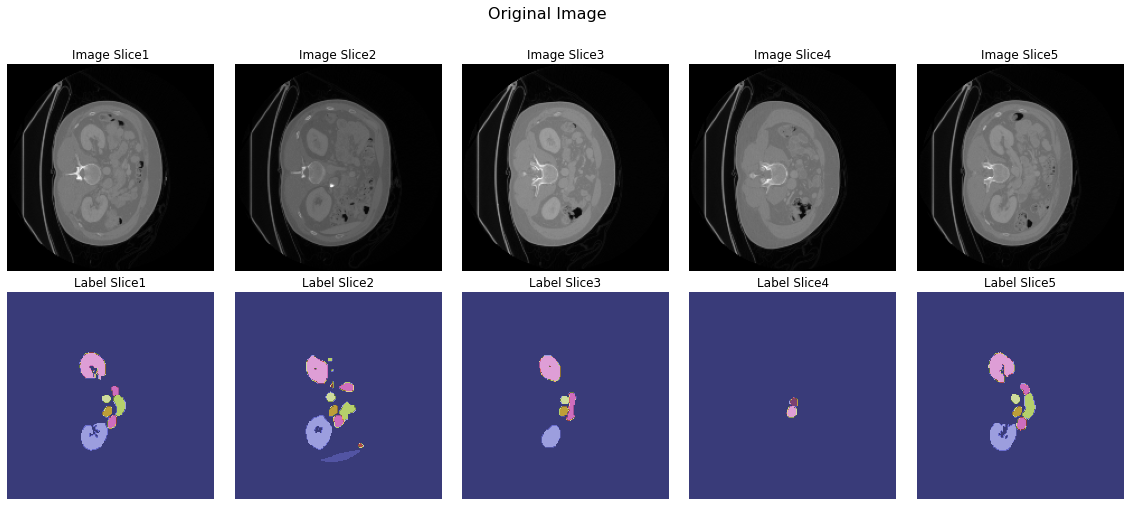

In [7]:
plot_images(first_val)


In [8]:
rand_elastic_transform = Rand3DElasticd(
                    keys=dm._dict_keys,
                    sigma_range=(9, 13),
                    magnitude_range=(0, 900),
                    padding_mode="border",
                    rotate_range=(math.pi / 12, math.pi / 12, math.pi / 12),
                    scale_range=((0.85, 1.25), (0.85, 1.25), (0.85, 1.25)),
                    prob=1,
                    mode=("bilinear", "nearest"),
                )

In [9]:
elastic_val = rand_elastic_transform(first_val)

/home/safal/flare/.venv/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


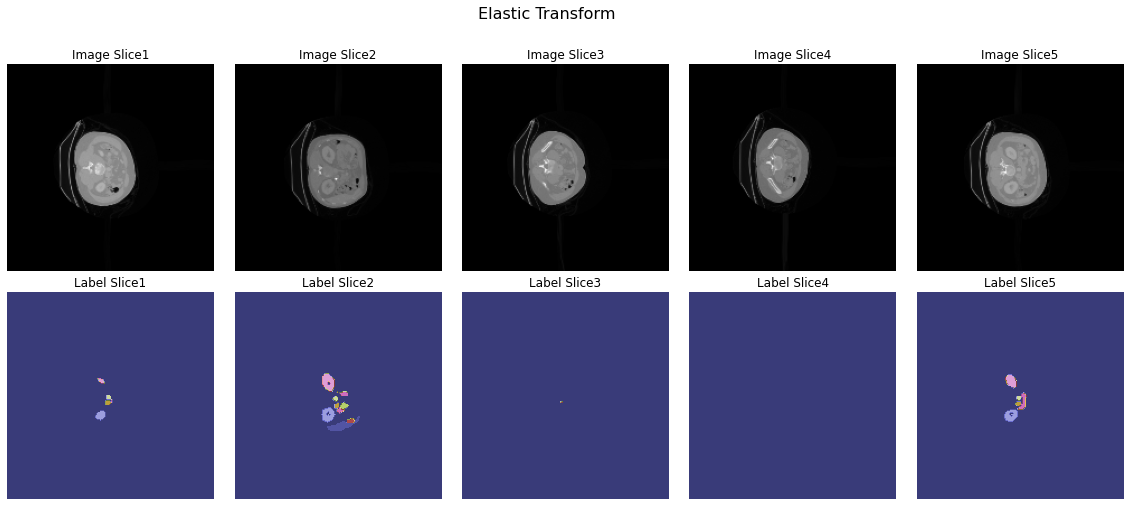

In [10]:
plot_images(elastic_val, "Elastic Transform")

In [11]:
rand_gaussian_noise = RandGaussianNoised(
                            keys="image",
                            prob=1,
                        )

In [12]:
noise_val = rand_gaussian_noise(elastic_val)

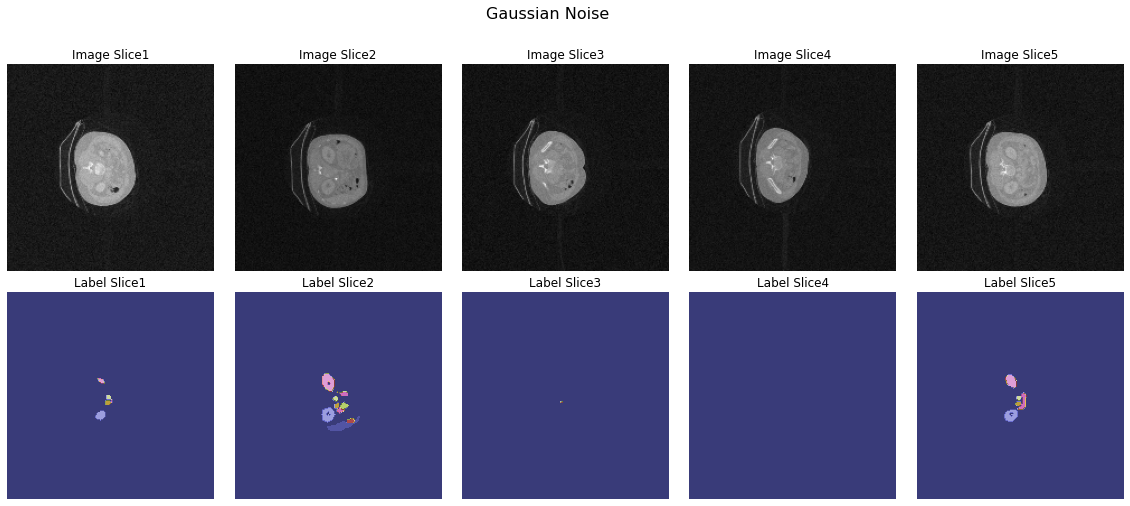

In [13]:
plot_images(noise_val, "Gaussian Noise")


In [14]:
rand_gaussian_smooth = RandGaussianSmoothd(
                        keys="image",
                        sigma_x=(0.5, 1.5),
                        sigma_y=(0.5, 1.5),
                        sigma_z=(0.5, 1.5),
                        prob=1,
                    )

In [15]:
smooth_val = rand_gaussian_smooth(noise_val)

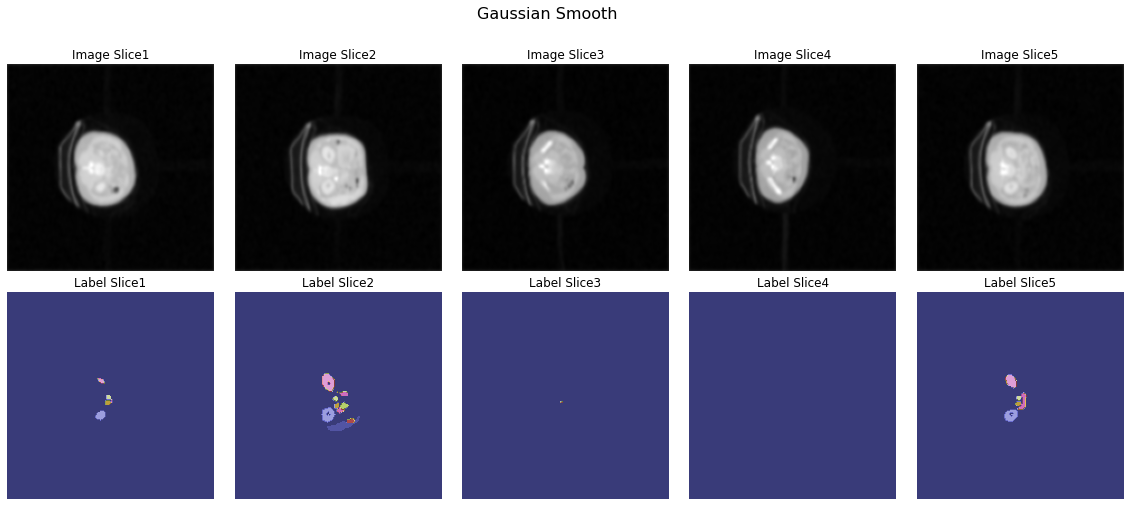

In [16]:
plot_images(smooth_val, "Gaussian Smooth")

In [17]:
rand_scale_intensity = RandScaleIntensityd(keys="image", factors=(0.7, 1.3), prob=1)

In [18]:
intensity_val = rand_scale_intensity(smooth_val)

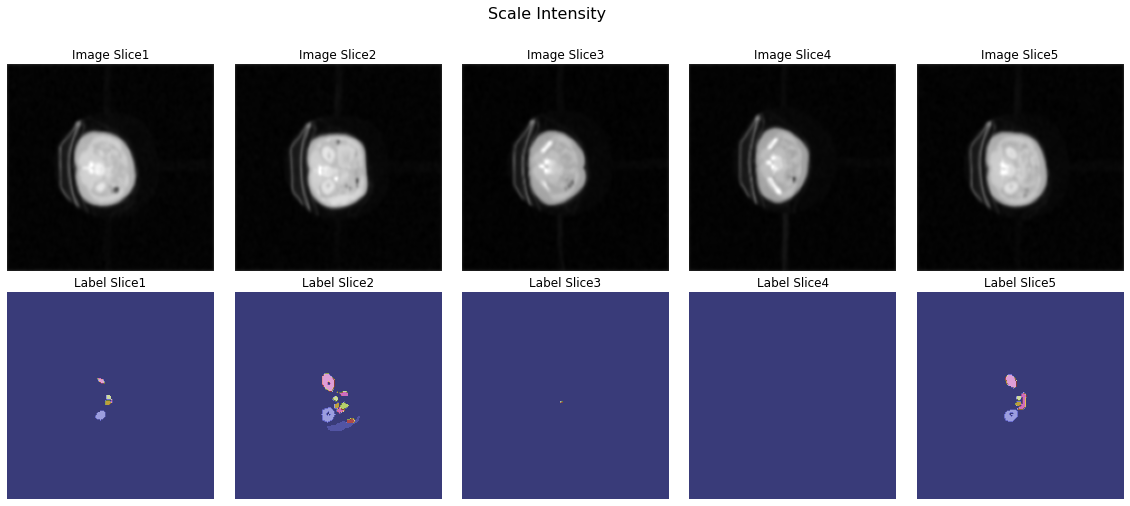

In [19]:
plot_images(intensity_val, "Scale Intensity")

In [20]:
rand_adjust_contrast = RandAdjustContrastd(keys="image", gamma=(0.65, 1.5), prob=1)

In [21]:
contrast_val = rand_adjust_contrast(intensity_val)

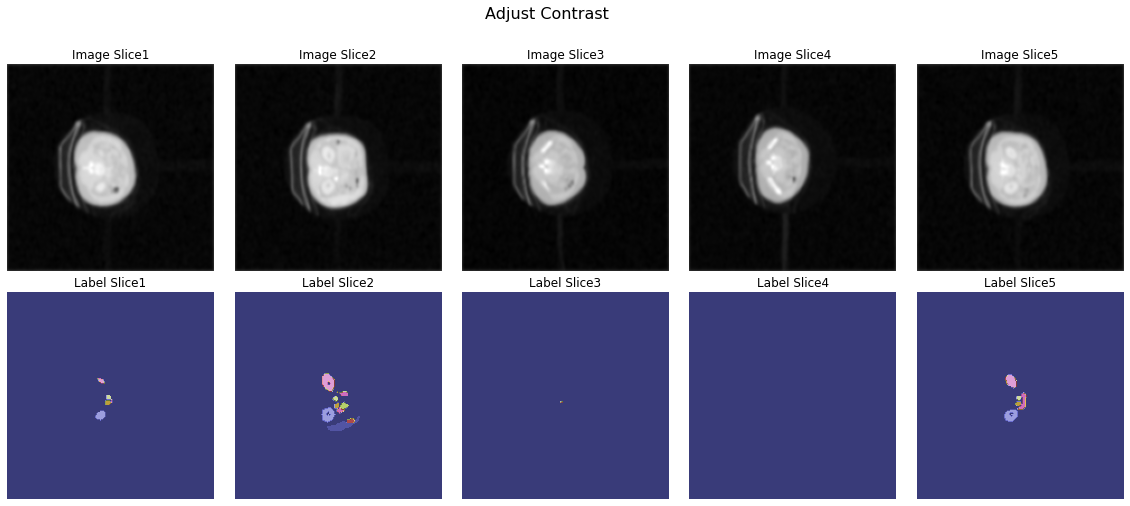

In [22]:
plot_images(contrast_val, "Adjust Contrast")

In [23]:
sim_low_res = SimulateLowResolutiond(keys="image", zoom_range=0.5, prob=1)

In [24]:
low_res_val = sim_low_res(first_val)

In [25]:
sim_low_res._scale

0.7359116205984491

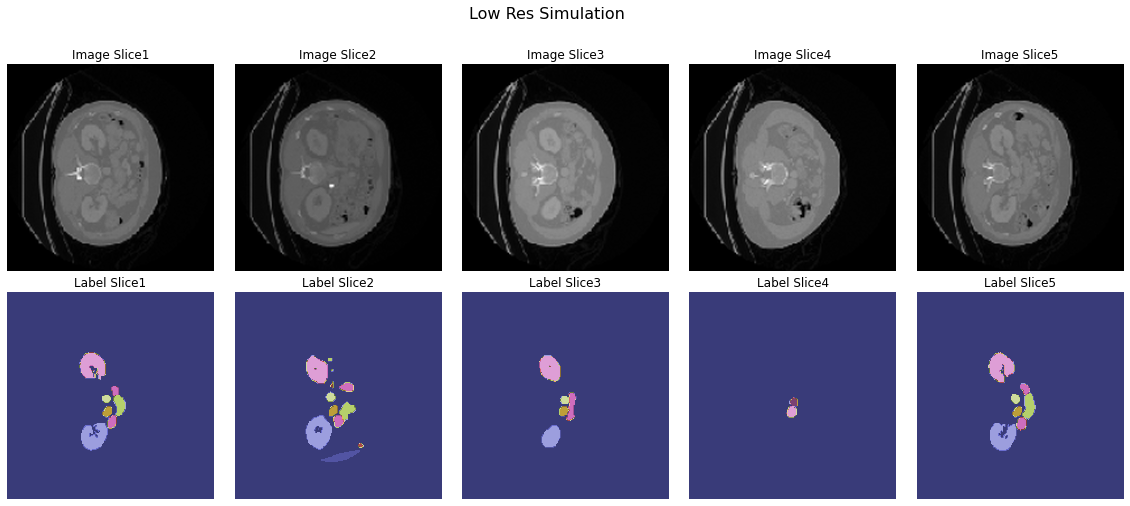

In [26]:
plot_images(low_res_val, "Low Res Simulation")